# Transfer learning (en vision)

Modifié de https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html



Il y a deux principaux scénarios d'apprentissage par transfert :

- **Finetuning** : Au lieu d'une initialisation aléatoire, nous
   initialisons le réseau avec un réseau pré-entraîné, sur ImageNet par exemple. Le reste de l'apprentissage se déroule comme d'habitude.

- **Extraction de features fixes** : dans ce cas, nous allons geler les poids
   pour tout le réseau à l'exception de la dernière couche entièrement connectée, responsable de la classification.Cette dernière couche entièrement connectée est remplacée par une nouvelle couche avec des poids aléatoires et seule cette couche est entraînée.

Pour en savoir plus, en particulier sur des critères permettant de choisir l'une ou l'autre approche, voir par exemple https://cs231n.github.io/transfer-learning/

In [ ]:
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

# manière 1 :
# model = convnext_tiny(weights="IMAGENET1K_V1")

# manière 2 :
weights = ConvNeXt_Tiny_Weights.DEFAULT
model = convnext_tiny(weights=weights)

# Set model to eval mode
model.eval()

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


  0%|          | 0.00/109M [00:00<?, ?B/s]

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [ ]:
# print(model)

On récupère en une ligne les transformations faites sur les images spécifiques à ce modèle et qu'il faut appliquer à toute image nouvelle à tester :  

In [ ]:
preprocess = weights.transforms()

D'après la doc, cela correspond à :

https://pytorch.org/vision/main/models/generated/torchvision.models.convnext_tiny.html#torchvision.models.convnext_tiny

"preprocessing operations: Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. The images are resized to resize_size=[236] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224]. Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
"

## Charger les données

Nous utiliserons torchvision et torch.utils.data pour charger les données.

Le problème que nous allons résoudre aujourd'hui est d'entrainer un modèle pour classifier **fourmis** et **abeilles**.

Nous disposons d'environ 120 images d'entraînement pour les fourmis et les abeilles. Il y a 75 images de validation pour chaque classe.

Ce jeu de données (issu d'ImageNet) est très petit pour entraîner un réseau profond à partir de zéro. Puisque nous utilisons l'apprentissage par transfert, nous devrions pouvoir généraliser raisonnablement bien.


In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2023-03-08 13:53:15--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.222.139.90, 52.222.139.21, 52.222.139.109, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.222.139.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  37.5MB/s    in 1.2s    

2023-03-08 13:53:17 (37.5 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [ ]:
!unzip -q hymenoptera_data.zip

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True

In [ ]:
data_dir = 'hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          preprocess)
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)
class_names = image_datasets['train'].classes
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)

{'train': 244, 'val': 153}
['ants', 'bees']


Visualisation

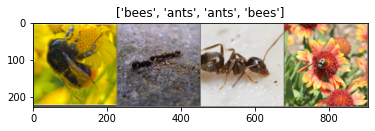

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Testons le modèle

In [ ]:
def visualize_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    # fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            max_values, preds = torch.max(outputs, 1)

            # break
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                category_name = weights.meta["categories"][preds[j]]
                # print(f"{category_name}: {100 * torch.sigmoid(max_values[j]).item():.1f}%")
                ax.set_title(f'predicted: {category_name} {100 * torch.sigmoid(max_values[j]).item():.1f}%')
                inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                plt.imshow(inp)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

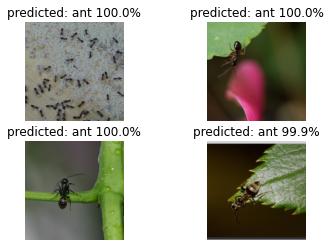

In [ ]:
visualize_predictions(model, num_images=4)

On voit que les prédictions sont presque toujours exactes... Sauf que le modèle prédit 1000 classes, donc parfois "nid d'abeilles" ("honeycomb") au lieu d'abeille tout court...

# Une fonction de train générique

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Visualiser des prédictions sur deux classes

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Apprentissage par transfert 1 : finetuning

In [ ]:
model_ft = model

# récupérer la dimension des inputs à la couche de classification de ConvNeXt :
num_ftrs = model_ft.classifier[-1].in_features
num_ftrs

768

In [ ]:
model_ft = model

# récupérer la dimension des inputs à la couche de classification de ConvNeXt :
num_ftrs = model_ft.classifier[-1].in_features
print(num_ftrs)
# remplacer la couche linéaire du classifieur par un nouvelle couche à deux neurones de sortie :
model_ft.classifier[-1] = nn.Linear(num_ftrs,2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Tous les poids vont être optimisés ici :
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Diminuer LR d'un facteur 0.1 chaque 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

768


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=3)

Epoch 0/2
----------
train Loss: 0.4856 Acc: 0.7049
val Loss: 0.2562 Acc: 0.8889

Epoch 1/2
----------
train Loss: 0.1353 Acc: 0.9426
val Loss: 0.2406 Acc: 0.8889

Epoch 2/2
----------
train Loss: 0.1464 Acc: 0.9385
val Loss: 0.1120 Acc: 0.9542

Training complete in 0m 26s
Best val Acc: 0.954248


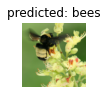

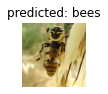

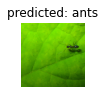

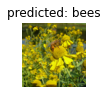

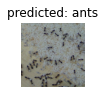

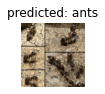

In [ ]:
visualize_model(model_ft)

# Apprentissage par transfert 2 : extraction de features puis classifieur

In [ ]:
model_extract = model
# récupérer la dimension des inputs à la couche de classification de ConvNeXt :
num_ftrs = model_ft.classifier[-1].in_features
print(num_ftrs)

# "geler" les poids de model_extract :
for param in model_extract.parameters():
  param.require_grad = False

# remplacer la couche linéaire du classifieur par un nouvelle couche à deux neurones de sortie :
model_ft.classifier[-1] = nn.Linear(num_ftrs,2)

model_extract = model_extract.to(device)

criterion = nn.CrossEntropyLoss()

# Tous les poids vont être optimisés ici :
optimizer_ft = optim.SGD(model_extract.parameters(), lr=0.001, momentum=0.9)

# Diminuer LR d'un facteur 0.1 chaque 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

768


In [ ]:
model_ft = train_model(model_extract, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=3)

Epoch 0/2
----------
train Loss: 0.1420 Acc: 0.9467
val Loss: 0.0947 Acc: 0.9477

Epoch 1/2
----------
train Loss: 0.0368 Acc: 0.9877
val Loss: 0.1168 Acc: 0.9608

Epoch 2/2
----------
train Loss: 0.0315 Acc: 0.9877
val Loss: 0.1208 Acc: 0.9608

Training complete in 0m 23s
Best val Acc: 0.960784


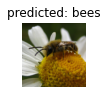

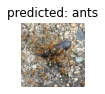

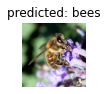

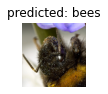

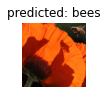

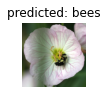

In [ ]:
visualize_model(model_ft)